In [37]:
import xarray as xr
from evaluations.confusion_table import  compute_score, plot_confusion_table, compute_all_scores
from products.plot_settings import METEOFRANCE_VAR_NAME,NASA_L3_VAR_NAME,NASA_PSEUDO_L3_VAR_NAME,PRODUCT_PLOT_NAMES
analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_4/analyses/confusion_table'
nasa_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
nasa_pseudo_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True)
analyses_dict = {METEOFRANCE_VAR_NAME: mf_metrics_ds, NASA_PSEUDO_L3_VAR_NAME: nasa_pseudo_l3_metrics_ds, NASA_L3_VAR_NAME: nasa_l3_metrics_ds}

In [27]:
from typing import Dict

from matplotlib import pyplot as plt


def plot_multiple_confusion_table(metrics_dict: Dict[str, xr.Dataset], title_complement: str):
    n_prods = len(metrics_dict)
    fig, axs = plt.subplots(ncols=n_prods, figsize=( 6*n_prods,5))
    fig.suptitle("Confusion table comparison - " + title_complement + '\n')
    for i, (product, metrics_ds) in enumerate(metrics_dict.items()):
        accuracy = compute_score(metrics_ds, 'accuracy').values
        plot_confusion_table(metrics_ds,axes=axs[i])
        axs[i].set_title(f'{PRODUCT_PLOT_NAMES[product]} - accuracy = {accuracy:.2f}')


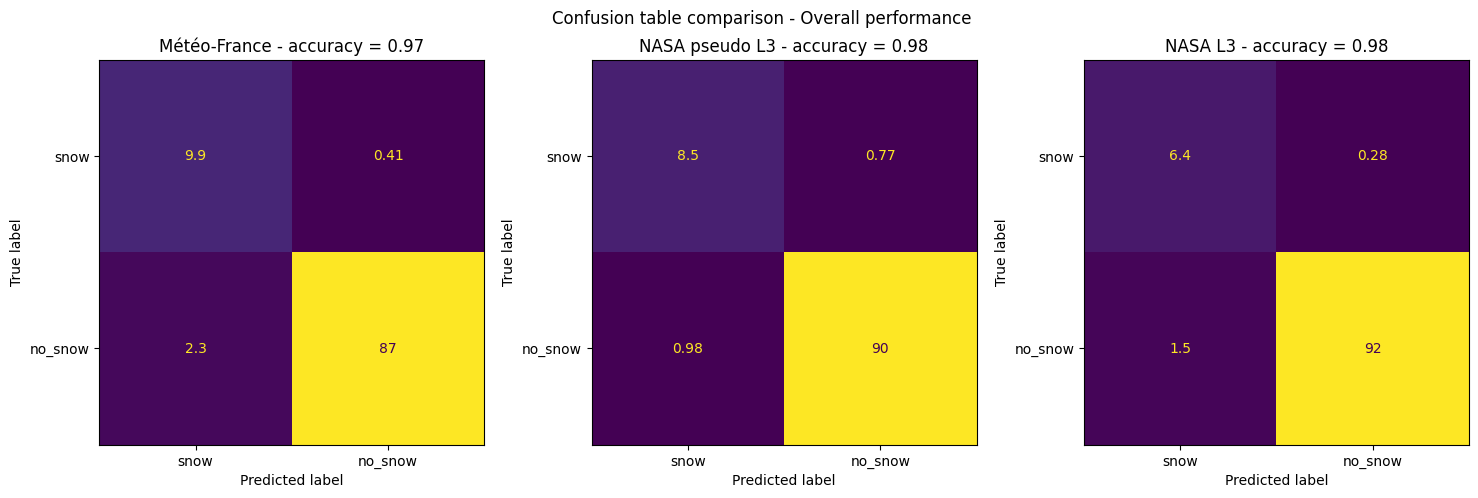

In [31]:
plot_multiple_confusion_table(metrics_dict=analyses_dict, title_complement='Overall performance')

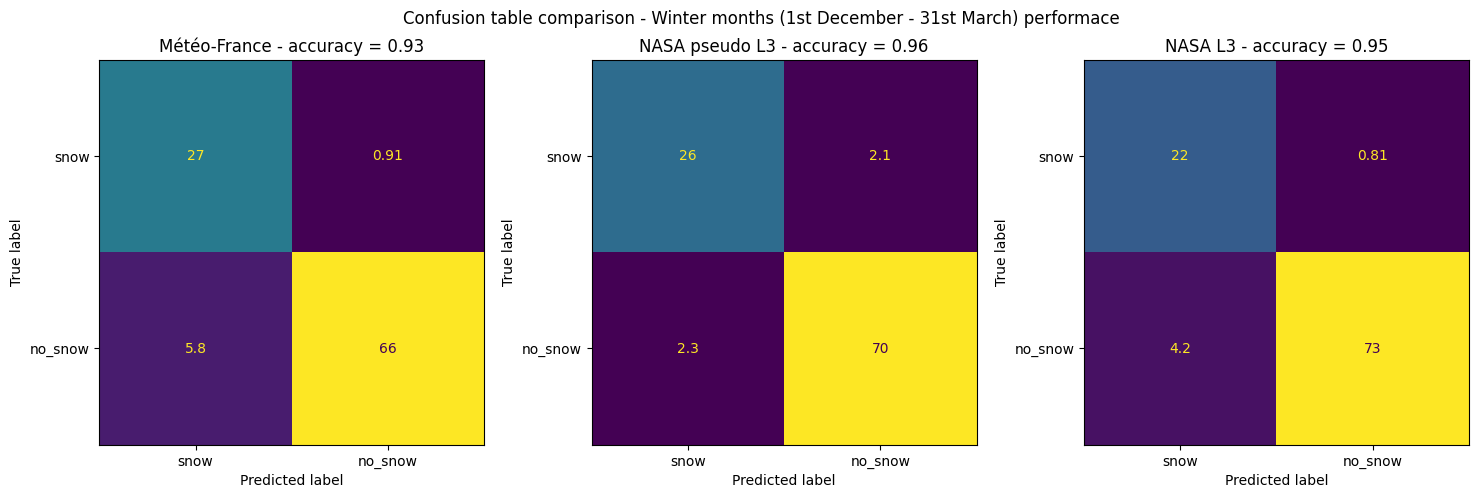

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-03')) for k,v in analyses_dict.items()}
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement='Winter months (1st December - 31st March) performance')

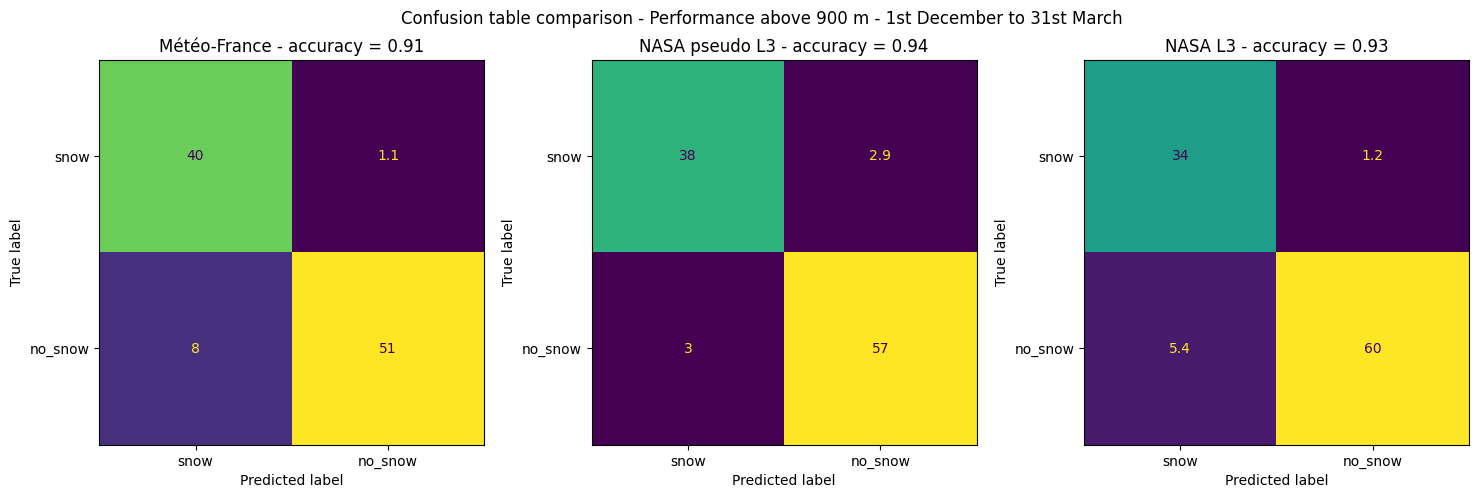

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2023-12','2024-03')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement='Performance above 900 m - 1st December to 31st March')

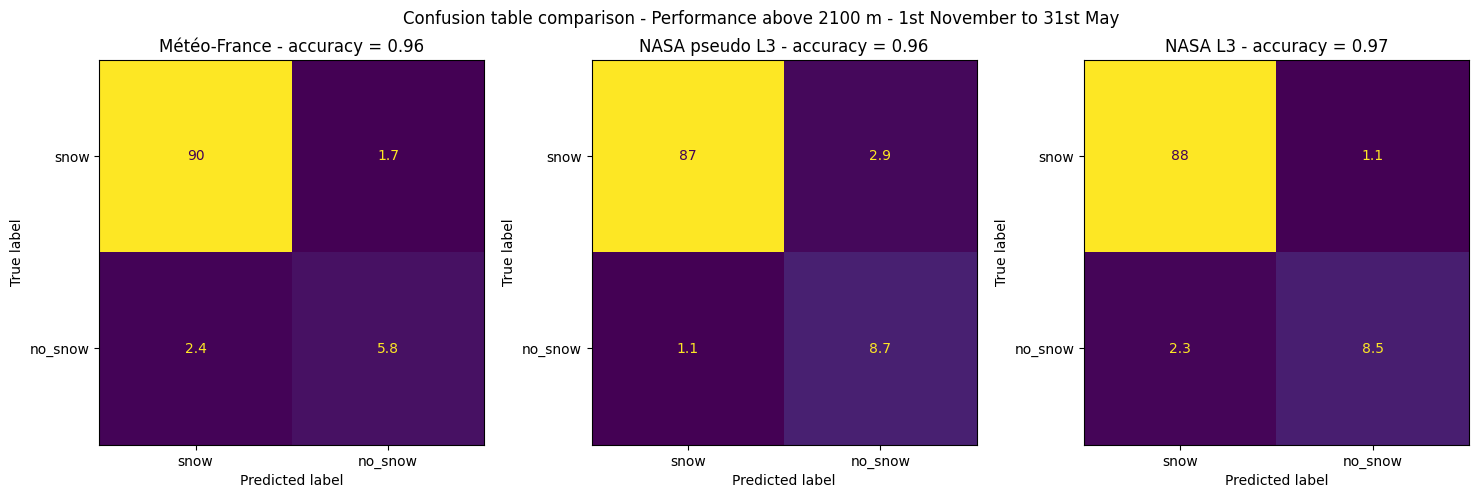

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2023-11','2024-05')).sel(altitude_bins=slice(2700,None)) for k,v in analyses_dict.items()}
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement='Performance above 2100 m - 1st November to 31st May')

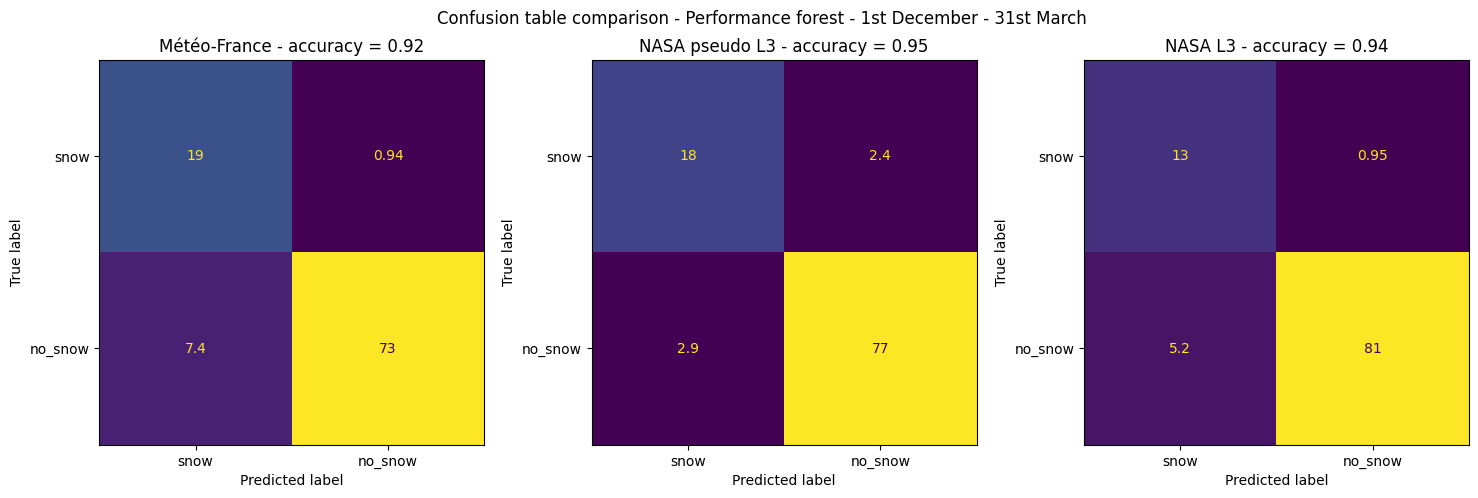

In [46]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-03')).sel(forest_mask=1) for k,v in analyses_dict.items()}
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement='Performance forest - 1st December - 31st March')

In [198]:
from typing import Dict
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# results_nasa = nasa_pseudo_l3_metrics_ds.sel(time='2023-12').groupby('slope_bins').map(compute_all_scores)
# results_mf = mf_metrics_ds.sel(time='2023-12').groupby('slope_bins').map(compute_all_scores)
# results = xr.concat([results_mf, results_nasa], pd.Index(["mf", "nasa"], name="product")).to_dataframe()
# results = results.reset_index(['slope_bins', 'product'])
# results = results.melt(id_vars=['product', 'slope_bins'], var_name='score', value_name='value')

def plot_multiple_scores_sns(metrics_dict: Dict[str, xr.Dataset],variable: str, variable_print:str,title_complement: str):
    results = []
    for i, (product, metrics_ds) in enumerate(metrics_dict.items()):
        results.append(metrics_ds.groupby(variable).map(compute_all_scores))
    results = xr.concat(results, pd.Index(list(metrics_dict.keys()), name="product")).to_dataframe()
    results = results.reset_index([variable, 'product'])
    results = results.melt(id_vars=['product', variable], var_name='score', value_name='value')
    sns.set_style("whitegrid")
    g = sns.relplot(results,x=variable,hue="score",y='value',col='product', kind='line',style='score',markers=True,col_wrap=np.min([len(metrics_dict),4]))
    g.figure.suptitle(f"Performance Metrics vs {variable_print} - {title_complement}", fontsize=14, fontweight="bold")

    # Adjust layout to make space for the title
    g.figure.subplots_adjust(top=0.85)
    g.set_axis_labels(variable_print, "Score")

def plot_multiple_scores(metrics_dict: Dict[str, xr.Dataset],variable: str ,title_complement: str):
    n_prods = len(metrics_dict)
    fig, axs = plt.subplots(ncols=n_prods, figsize=( 5*n_prods,4))
    fig.suptitle("Scores comparison - " + title_complement)
    for i, (product, metrics_ds) in enumerate(metrics_dict.items()):
        results = metrics_ds.groupby(variable).map(compute_all_scores)
        for dv in results:
            results[dv].plot.line('-*',ax=axs[i], label=dv)
        axs[i].set_ylabel('score')
        axs[i].set_title(f'{PRODUCT_PLOT_NAMES[product]}')
        axs[i].grid()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels,loc = (0, 0))
    

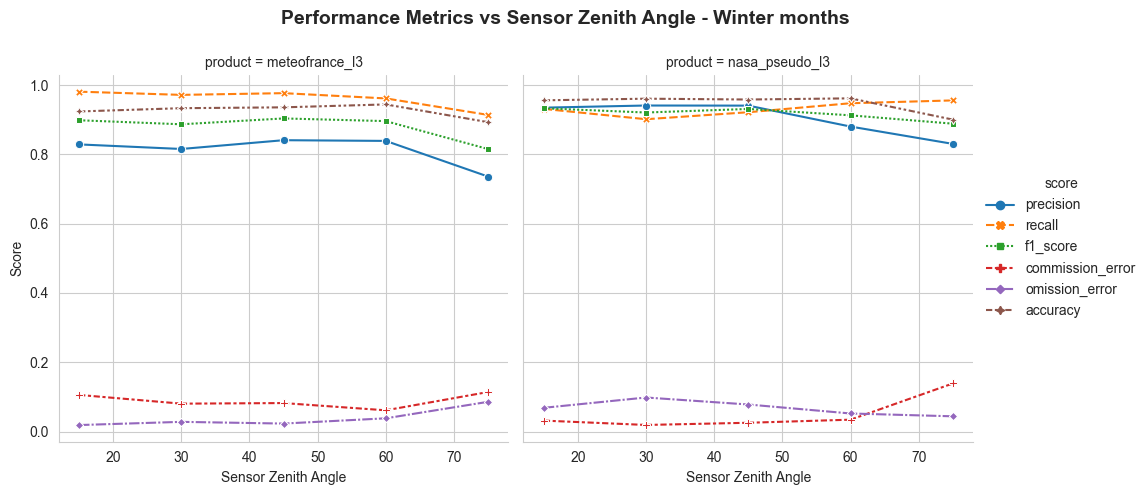

In [199]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-03'))for k,v in analyses_dict.items()}
selection_dict.pop('nasa_l3')
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='sensor_zenith_bins', variable_print='Sensor Zenith Angle',title_complement='Winter months')

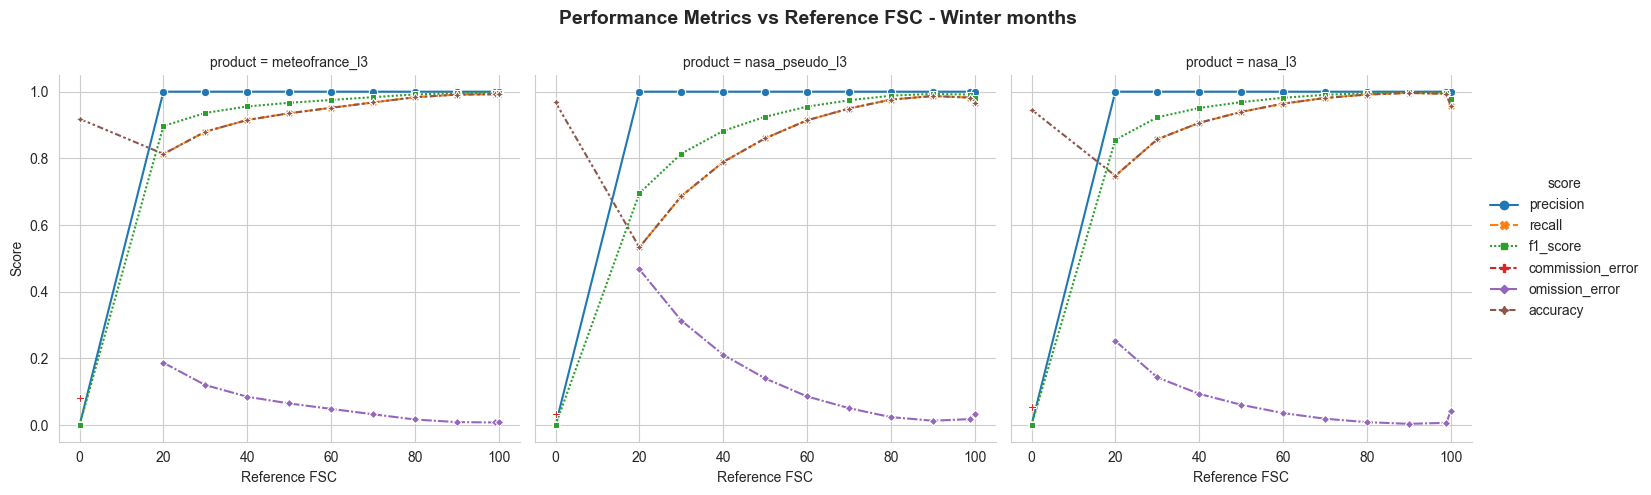

In [201]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-03'))for k,v in analyses_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='ref_bins', variable_print='Reference FSC',title_complement='Winter months')

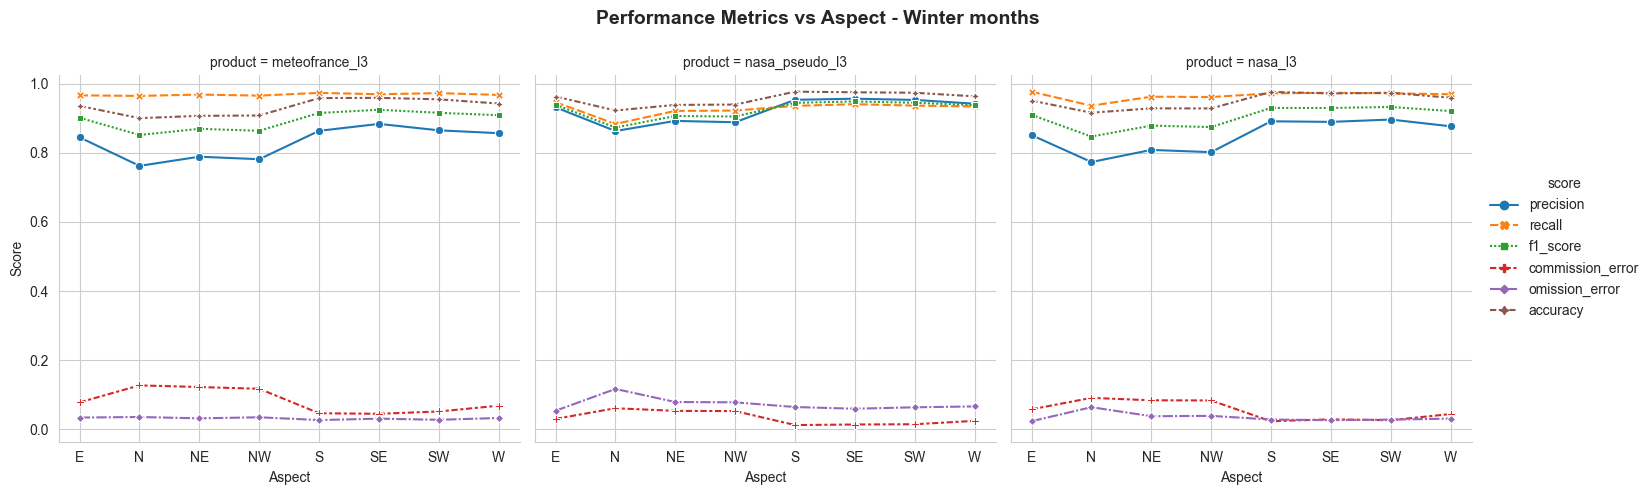

In [203]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-03'))for k,v in analyses_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='aspect_bins', variable_print='Aspect',title_complement='Winter months')

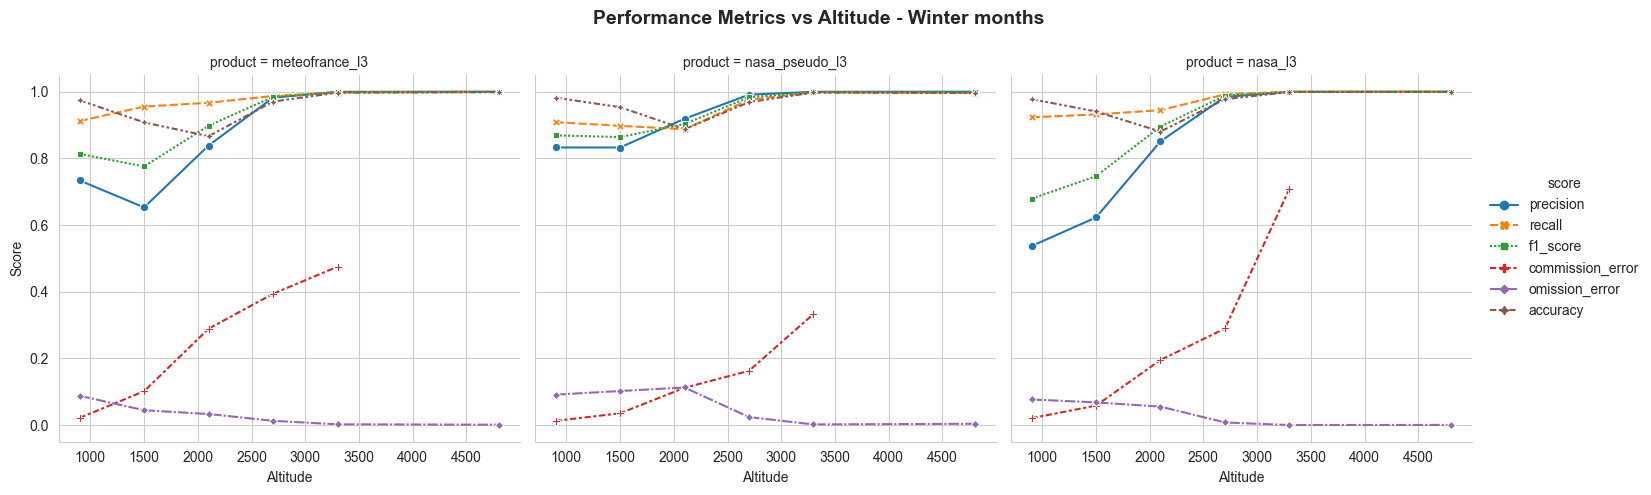

In [204]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-03'))for k,v in analyses_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='altitude_bins', variable_print='Altitude',title_complement='Winter months')

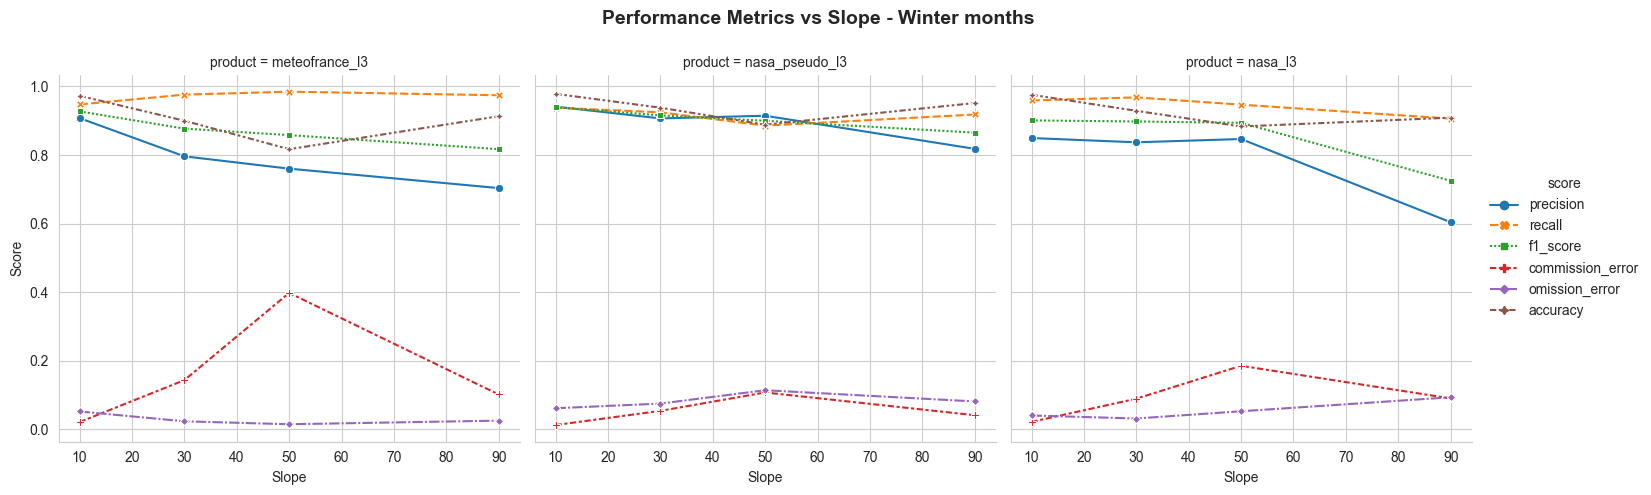

In [207]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-03'))for k,v in analyses_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='slope_bins', variable_print='Slope',title_complement='Winter months')

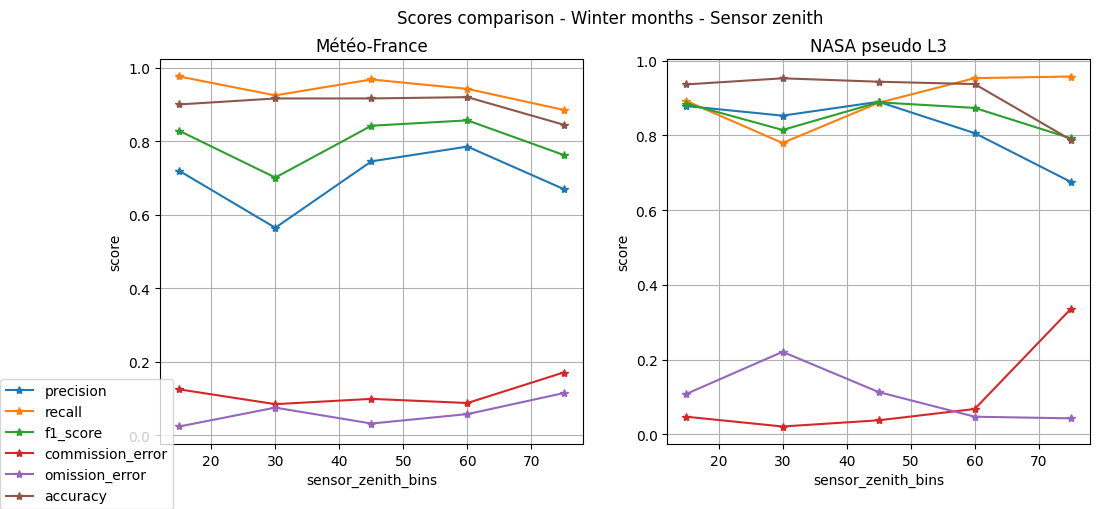

In [70]:
selection_dict = {k: v.sel(time=slice('2023-12','2024-01')).sel(forest_mask=1) for k,v in analyses_dict.items()}
selection_dict.pop('nasa_l3')
plot_multiple_scores(metrics_dict=selection_dict, variable='sensor_zenith_bins',title_complement='Winter months - Sensor zenith')

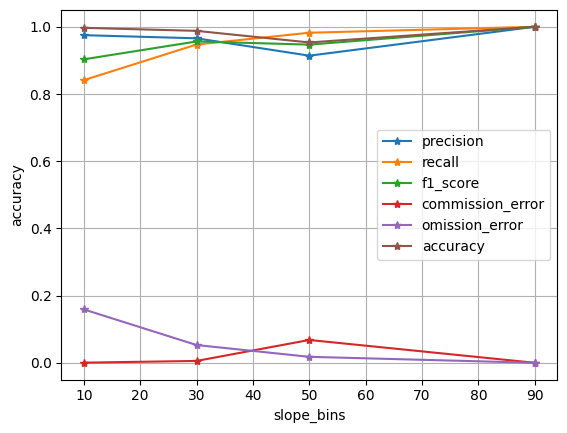

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = mf_metrics_ds.sel(sensor_zenith_bins=slice(45,None)).groupby('slope_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line('-*',ax=ax, label=dv)
ax.legend()
ax.grid()

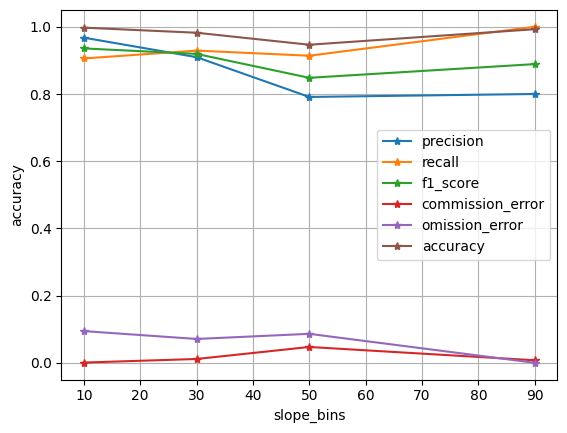

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = nasa_l3_metrics_ds.groupby('slope_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line('-*',ax=ax, label=dv)
ax.legend()
ax.grid()

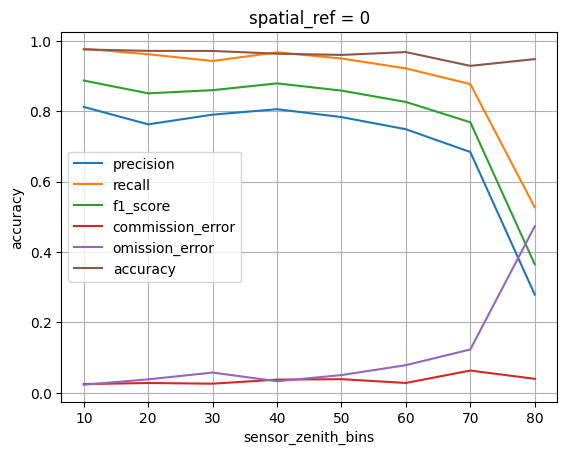

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = mf_metrics_ds.groupby('sensor_zenith_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line(ax=ax, label=dv)
ax.legend()
ax.grid()

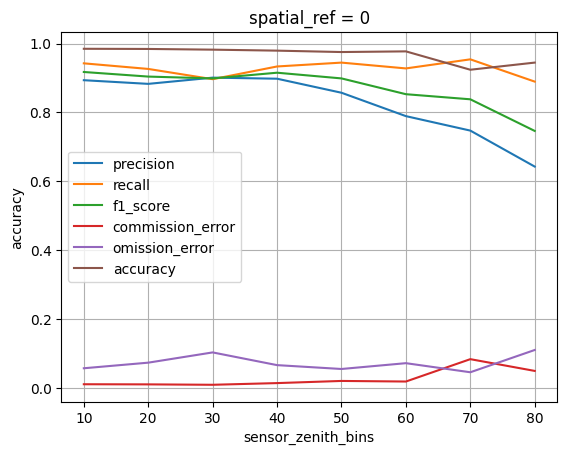

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = nasa_pseudo_l3_metrics_ds.groupby('sensor_zenith_bins').map(compute_all_scores)
for dv in results:
    results[dv].plot.line(ax=ax, label=dv)
ax.legend()
ax.grid()

In [ ]:
mf_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(accuracy)

<xarray.DataArray (sensor_zenith_bins: 9)> Size: 72B
array([0.98173406, 0.97584876, 0.97731227, 0.97847285, 0.96467257,
       0.97293504, 0.94169941, 0.98543834,        nan])
Coordinates:
    forest_mask_bins    float64 8B 0.0
    spatial_ref         int64 8B 0
  * sensor_zenith_bins  (sensor_zenith_bins) int64 72B 10 20 30 40 ... 70 80 255

In [7]:
nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(compute_score, ['false_alarm_ratio'])

<xarray.DataArray (sensor_zenith_bins: 9)> Size: 72B
array([0.04418219, 0.0581323 , 0.05144611, 0.04774437, 0.08324594,
       0.13511207, 0.17991348, 0.30024814,        nan])
Coordinates:
    forest_mask_bins    float64 8B 0.0
    spatial_ref         int64 8B 0
  * sensor_zenith_bins  (sensor_zenith_bins) int64 72B 10 20 30 40 ... 70 80 255

In [5]:
mf_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(compute_score, ['false_alarm_ratio'])

<xarray.DataArray (sensor_zenith_bins: 9)> Size: 72B
array([0.076175  , 0.12102034, 0.07612176, 0.06139751, 0.11482717,
       0.11918732, 0.18352708, 0.5       ,        nan])
Coordinates:
    forest_mask_bins    float64 8B 0.0
    spatial_ref         int64 8B 0
  * sensor_zenith_bins  (sensor_zenith_bins) int64 72B 10 20 30 40 ... 70 80 255

In [2]:
print('period')
print(nasa_l3_metrics_ds.coords['time'])

period
<xarray.DataArray 'time' (time: 314)> Size: 3kB
array(['2023-10-01T00:00:00.000000000', '2023-10-02T00:00:00.000000000',
       '2023-10-03T00:00:00.000000000', ..., '2024-09-28T00:00:00.000000000',
       '2024-09-29T00:00:00.000000000', '2024-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 3kB 2023-10-01 2023-10-02 ... 2024-09-30


NASA L3 
Overall accuracy: 0.9841477142737803
Forest accuracy: 0.9836846164594844
No forest accuracy: 0.9847692240347301
No snow accuracy: 0.9943018189623947
Snow accuracy: 0.8844665172358224


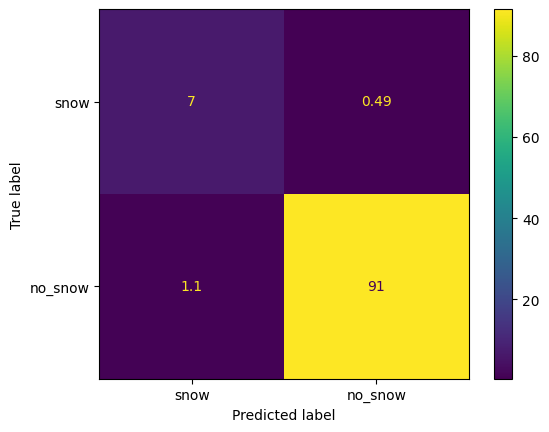

In [3]:
print("NASA L3 ")
print("Overall accuracy:", accuracy(nasa_l3_metrics_ds).values)
print("Forest accuracy:", accuracy(nasa_l3_metrics_ds.sel(forest_mask_bins=1)).values)
print("No forest accuracy:", accuracy(nasa_l3_metrics_ds.sel(forest_mask_bins=0)).values)
print("No snow accuracy:", accuracy(nasa_l3_metrics_ds.sel(ref_bins=0)).values)
print("Snow accuracy:", accuracy(nasa_l3_metrics_ds.isel(ref_bins=slice(1,None))).values)
plot_confusion_table(nasa_l3_metrics_ds.sel(ref_bins=nasa_l3_metrics_ds.ref_bins)) 

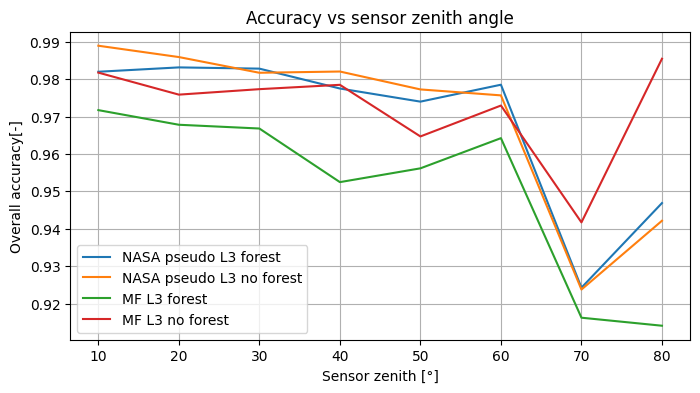

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
solar_zenith_bins = nasa_pseudo_l3_metrics_ds.coords['sensor_zenith_bins'].values
ax.plot(solar_zenith_bins, nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=1).groupby('sensor_zenith_bins').map(accuracy), label='NASA pseudo L3 forest')
ax.plot(solar_zenith_bins, nasa_pseudo_l3_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(accuracy), label='NASA pseudo L3 no forest')
ax.plot(solar_zenith_bins, mf_metrics_ds.sel(forest_mask_bins=1).groupby('sensor_zenith_bins').map(accuracy), label='MF L3 forest')
ax.plot(solar_zenith_bins, mf_metrics_ds.sel(forest_mask_bins=0).groupby('sensor_zenith_bins').map(accuracy), label='MF L3 no forest')
ax.set_title('Accuracy vs sensor zenith angle')
ax.set_xlabel('Sensor zenith [°]')
ax.set_ylabel('Overall accuracy[-]')
ax.grid(True)
ax.legend()

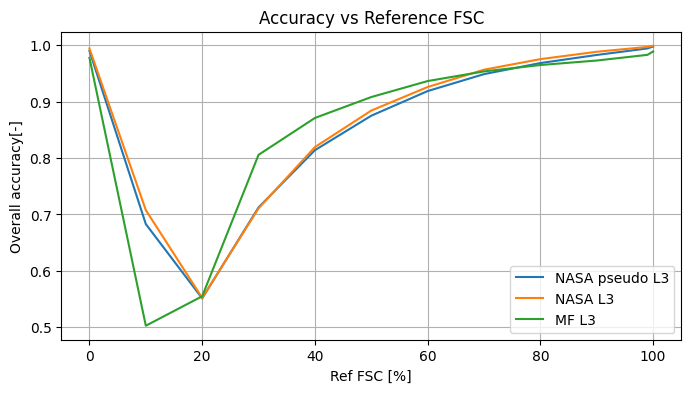

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
ref_fsc_bins = nasa_pseudo_l3_metrics_ds.coords['ref_bins'].values
ax.plot(ref_fsc_bins, nasa_pseudo_l3_metrics_ds.groupby('ref_bins').map(accuracy), label='NASA pseudo L3')
ax.plot(ref_fsc_bins, nasa_l3_metrics_ds.groupby('ref_bins').map(accuracy), label='NASA L3')
ax.plot(ref_fsc_bins, mf_metrics_ds.groupby('ref_bins').map(accuracy), label='MF L3')
ax.set_title('Accuracy vs Reference FSC')
ax.set_xlabel('Ref FSC [%]')
ax.set_ylabel('Overall accuracy[-]')
ax.grid(True)
ax.legend()